In [114]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import gc

In [115]:
def free():
    return gc.collect()

class Data():
    def __init__(self,train,test):
        self.test = test
        self.train = train
        print('train : ' + str(self.train.shape))
        print('test: ' + str(self.test.shape))
        
    def describe(self,test=False):
        if test:
            return self.train.describe(), self.test.describe()
        return self.train.describe()
    
    def columns(self):
        return [i for i in self.test.columns if i not in ['transaction_id','target']]
    
    def getCustom(self,substring):
        return [i for i in self.columns() if substring in i]

    def drop(self,colName):
        self.train = self.train.drop(colName,axis=1)
        self.test = self.test.drop(colName,axis=1)

    def scaler(self,colName):
        from sklearn.preprocessing import StandardScaler
        std_scale = StandardScaler().fit(self.test[colName])
        self.test[colName] = std_scale.transform(self.test[colName])
        self.train[colName] = std_scale.transform(self.train[colName])

    def decomposition(self):
        classSet = list(set(self.train['target']))
        self.classDict = { i: [1 if j==i else 0 for j in self.train['target']] for i in classSet}

In [116]:
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self,x_train,y_train):
        return self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def predict_proba(self,x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importance(self,x,y):
        return self.clf.fit(x,y).feature_importances_

In [117]:
data = Data(pd.read_csv('../Data/cleaned_train.csv').drop(['transaction_id'],1),pd.read_csv('../Data/cleaned_test.csv').drop(['transaction_id'],1))

train : (348135, 29)
test: (523466, 28)


In [118]:
ntest = data.test.shape[0]
ntrain = data.train.shape[0]
SEED = 167681684
NFOLDS = 5
kf_tr = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf_ts = KFold(ntest, n_folds= NFOLDS, random_state=SEED)
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    for (train_index_tr,test_index_tr),(train_index_ts,test_index_ts) in zip(kf_tr,kf_ts):
        x_train_tr = x_train[train_index_tr]
        y_train_tr = y_train[train_index_tr]
        x_test_tr = x_train[test_index_tr]
        x_test_ts = x_test[test_index_ts]
        
        clf.train(x_train_tr,y_train_tr)
        
#       Modified 
        ans_tr=clf.predict_proba(x_test_tr)
        y_pred_tr=[]
        for i in ans_tr:
            y_pred_tr.append(i[1])
        
        ans_ts=clf.predict_proba(x_test_ts)
        y_pred_ts=[]
        for i in ans_ts:
            y_pred_ts.append(i[1])
#       ////////////////////////////////////////////////////
        oof_train[test_index_tr] = y_pred_tr   # tr_list
        oof_test[test_index_ts] = y_pred_ts    # ts_list
        
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [119]:
ntest = data.test.shape[0]
ntrain = data.train.shape[0]
SEED = 6734637
NFOLDS = 5
kf_tr = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf_ts = KFold(ntest, n_folds= NFOLDS, random_state=SEED)
def get_XGoof(params, x_train, y_train, x_test,num_rounds=None):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    for (train_index_tr,test_index_tr),(train_index_ts,test_index_ts) in zip(kf_tr,kf_ts):
        dtrain = xgb.DMatrix(data=x_train[train_index_tr], label=y_train[train_index_tr])
        dte = xgb.DMatrix(data=x_train[test_index_tr])
        dtest = xgb.DMatrix(data=x_test[test_index_ts])   
        
        bst = xgb.train(params,dtrain,num_boost_round=num_rounds)
        oof_train[test_index_tr] = bst.predict(dte)
        oof_test[test_index_ts] = bst.predict(dtest)
        
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [121]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 800,
#      'warm_start': True, 
     #'max_features': 0.2,
#     'max_depth': 6,
    'min_samples_leaf': 50,
#     'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':850,
    #'max_features': 0.5,
#     'max_depth': 8,
    'min_samples_leaf': 50,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 600,
    'learning_rate' : 0.05,
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 700,
     #'max_features': 0.2,
    'max_depth': 7,
    'min_samples_leaf': 2,
    'verbose': 1,
    'learning_rate':0.02,
    'subsample':0.9
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.025,
    }

In [122]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 650
lgb_params['max_bin'] = 10
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 500
lgb_params['seed'] = 9341389
lgb_params['n_jobs']=-1
lgb_params['objective']='binary'


lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.01
lgb_params2['colsample_bytree'] = 0.9   
lgb_params2['subsample'] = 0.9
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 92341769
lgb_params2['n_jobs']=-1
lgb_params2['objective']='binary'


lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 6
lgb_params3['learning_rate'] = 0.01
lgb_params3['seed'] = 9544947
lgb_params3['n_jobs']=-1
lgb_params3['objective']='binary'

In [123]:
y_train = data.train['target'].ravel()
train = data.train[data.columns()]
x_train = train.values # Creates an array of the train data
x_test = data.test[data.columns()].values # Creats an array of the test data

In [124]:
y_train.shape,train.shape

((348135,), (348135, 28))

In [125]:
x_train.shape,x_test.shape

((348135, 28), (523466, 28))

In [126]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
lgb = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lgb_params2) # LGBMClassifier(**lgb_params)
lgb1 = SklearnHelper(clf=LGBMClassifier, seed=SEED, params=lgb_params3) # LGBMClassifier(**lgb_params)

In [127]:
rf1_oof_train, rf1_oof_test = get_oof(rf,x_train, y_train, x_test) # random forest
print('Completed')

Completed


In [128]:
pd.DataFrame(rf1_oof_train).to_csv('../Stacked data/rf1_oof_train.csv',index=False)
pd.DataFrame(rf1_oof_test).to_csv('../Stacked data/rf1_oof_test.csv',index=False)

In [129]:
sub1,sub2=pd.read_csv('../Stacked data/rf1_oof_test.csv'),pd.read_csv('../Submissions/XGB_3_chk.csv')['target']
pd.concat([sub1,sub2],axis=1).corr()

0    target
0       1.000000  0.919859
target  0.919859  1.000000

In [130]:
gb1_oof_train, gb1_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print('Completed')

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6698           0.0087           44.19m
         2           0.6603           0.0078           41.38m
         3           0.6554           0.0070           40.04m
         4           0.6476           0.0062           38.95m
         5           0.6431           0.0053           38.28m
         6           0.6381           0.0049           37.82m
         7           0.6322           0.0044           37.54m
         8           0.6295           0.0039           37.09m
         9           0.6264           0.0041           36.76m
        10           0.6220           0.0035           38.09m
        20           0.5965           0.0018           42.90m
        30           0.5796           0.0013           40.07m
        40           0.5717           0.0009           39.69m
        50           0.5626           0.0006           38.63m
        60           0.5565           0.0005           39.27m
       

In [131]:
pd.DataFrame(gb1_oof_train).to_csv('../Stacked data/gb1_oof_train.csv',index=False)
pd.DataFrame(gb1_oof_test).to_csv('../Stacked data/gb1_oof_test.csv',index=False)

In [132]:
sub1,sub2=pd.read_csv('../Stacked data/gb1_oof_test.csv'),pd.read_csv('../Submissions/XGB_3_chk.csv')['target']
pd.concat([sub1,sub2],axis=1).corr()

0    target
0       1.000000  0.944734
target  0.944734  1.000000

In [133]:
et1_oof_train, et1_oof_test = get_oof(et,x_train, y_train, x_test) # Gradient Boost
print('Completed')

Completed


In [134]:
pd.DataFrame(et1_oof_train).to_csv('../Stacked data/et1_oof_train.csv',index=False)
pd.DataFrame(et1_oof_test).to_csv('../Stacked data/et1_oof_test.csv',index=False)

In [135]:
sub1,sub2=pd.read_csv('../Stacked data/et1_oof_test.csv'),pd.read_csv('../Submissions/XGB_3_chk.csv')['target']
pd.concat([sub1,sub2],axis=1).corr()

0    target
0       1.000000  0.810672
target  0.810672  1.000000

In [136]:
lgb1_oof_train, lgb1_oof_test = get_oof(lgb,x_train, y_train, x_test) # light Gradient Boost
print('Completed')

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please us

Completed


In [137]:
pd.DataFrame(lgb1_oof_train).to_csv('../Stacked data/lgb1_oof_train.csv',index=False)
pd.DataFrame(lgb1_oof_test).to_csv('../Stacked data/lgb1_oof_test.csv',index=False)

In [138]:
sub1,sub2=pd.read_csv('../Stacked data/lgb1_oof_test.csv'),pd.read_csv('../Submissions/XGB_3_chk.csv')['target']
pd.concat([sub1,sub2],axis=1).corr()

0    target
0       1.000000  0.985592
target  0.985592  1.000000

In [139]:
lgb2_oof_train, lgb2_oof_test = get_oof(lgb1,x_train, y_train, x_test) # light Gradient Boost
print('Completed')

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please us

Completed


In [140]:
pd.DataFrame(lgb2_oof_train).to_csv('../Stacked data/lgb2_oof_train.csv',index=False)
pd.DataFrame(lgb2_oof_test).to_csv('../Stacked data/lgb2_oof_test.csv',index=False)

In [141]:
sub1,sub2=pd.read_csv('../Stacked data/lgb2_oof_test.csv'),pd.read_csv('../Submissions/XGB_3_chk.csv')['target']
pd.concat([sub1,sub2],axis=1).corr()

0    target
0       1.000000  0.988199
target  0.988199  1.000000

In [13]:
# params = {}
# params['objective'] = 'binary:logistic'
# params['eta'] = 0.0075
# params['silent'] = True
# params['max_depth'] = 6
# params['subsample'] = 0.9
# params['colsample_bytree'] = 0.9
# params['nthread']=-1
# params['eval_metric']='auc'

# params = {}
# params['objective'] = 'binary:logistic'
# params['eta'] = 0.0045
# params['silent'] = True
# params['max_depth'] = 7
# params['subsample'] = 0.9
# params['colsample_bytree'] = 0.9
# params['nthread']=-1
# params['eval_metric']='auc'

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.007
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['nthread']=-1
params['eval_metric']='auc'
# params['scale_pos_weight']=0.15

In [14]:
# xg3_oof_train, xg3_oof_test = get_XGoof(params,x_train,y_train,x_test,num_rounds=5410)
# print('completed')

In [143]:
# pd.DataFrame(xg3_oof_train).to_csv('../Stacked data/xg3_oof_train.csv',index=False)
# pd.DataFrame(xg3_oof_test).to_csv('../Stacked data/xg3_oof_test.csv',index=False)

In [144]:
# sub1,sub2=pd.read_csv('../Stacked data/xg3_oof_test.csv'),pd.read_csv('../Submissions/XGB_3_chk.csv')['target']

In [145]:
# pd.concat([sub1,sub2],axis=1).corr()

0    target
0       1.000000  0.994668
target  0.994668  1.000000

In [132]:
sub1.head(),sub2.head()

(          0
 0  0.057229
 1  0.060867
 2  0.059091
 3  0.060154
 4  0.065964, 0    0.063202
 1    0.059821
 2    0.053791
 3    0.061454
 4    0.063561
 Name: target, dtype: float64)

In [42]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

In [43]:
def roc_auc(pred, dtrain):
    label = dtrain.get_label()
    acc = roc_auc_score(label, pred)
    return 'roc-auc : ', acc

In [44]:
x_tr,x_ts,y_tr,y_ts=train_test_split(x_train,y_train,test_size=0.2)

In [137]:
# dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtrain = xgb.DMatrix(data=x_tr, label=y_tr)
dvalid = xgb.DMatrix(data=x_ts,label=y_ts)
dtest = xgb.DMatrix(data=x_test)

In [138]:
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]

In [45]:
free()

1081

In [88]:
# clf1_1 = xgb.train(params, dtrain, 20000, watchlist, maximize=True, verbose_eval=50, early_stopping_rounds=360)

# #[4141]	train-auc:0.825794	eval-auc:0.733658  eta=.0045
#[1390]	train-auc:0.744152	eval-auc:0.729205      eta=.0025
#[935]	train-auc:0.728252	eval-auc:0.723505      eta=.0045 depth=6
# [1721]	train-auc:0.734281	eval-auc:0.722949  eta=.0025 depth=7
# [1259]	train-auc:0.797369	eval-auc:0.731793  eta=.01  depth=7 260  1360
# [1180]	train-auc:0.768526	eval-auc:0.728929  eta=.01  depth=6 260  1252
# [5240]	train-auc:0.838572	eval-auc:0.72659   eta=.007  depth=6 360  5410

In [107]:
clf1_2 = xgb.train(params, dtrain, 1360)

In [81]:
import pickle
pickle.dump(clf1_2,open('XGB1_.sav','wb'))

In [108]:
sub=pd.DataFrame()
pred = clf1_2.predict(dtest)
## make submission
sub['transaction_id']=pd.read_csv('../Data/cleaned_test.csv')['transaction_id']
sub['target'] = pred
sub.to_csv('../Submissions/XGB_3_chk.csv', index=False)


In [69]:
ld=pd.read_csv('XGB_1.csv')

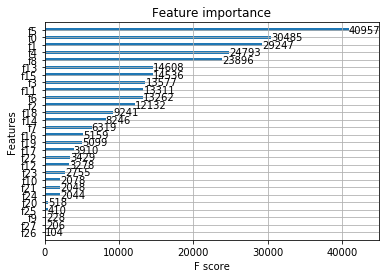

In [83]:
xgb.plot_importance(clf1_2, ax=None, height=0.4, xlim=None,
                    ylim=None, title='Feature importance',
                    xlabel='F score', ylabel='Features',
                    importance_type='weight',
                    grid=True)
plt.figure(figsize=(14,10))
plt.show()

# Random forest test

In [46]:
rf.train(x_tr,y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=6734637, verbose=0,
            warm_start=False)

In [47]:
tg=np.array(x_ts)

In [61]:
ans=rf.predict_proba(tg)

In [77]:
y_pred=[]
for i in ans:
    y_pred.append(i[1])

In [79]:
roc_auc_score(y_ts,y_pred)

0.72357555566153042

In [78]:
y_pred[:2]

[0.060492574999312418, 0.070774657559287538]

In [60]:
import pickle

In [59]:
pickle.dump(rf,open('random.sav','wb'))

# Extra trees test

In [80]:
et.train(x_tr,y_tr)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
           oob_score=False, random_state=6734637, verbose=0,
           warm_start=False)

In [81]:
ans=et.predict_proba(tg)
y_pred=[]
for i in ans:
    y_pred.append(i[1])
roc_auc_score(y_ts,y_pred)

0.71979532821432901

# Gradient boosting test

In [82]:
gb.train(x_tr,y_tr)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6720           0.0082           17.73m
         2           0.6651           0.0072           18.36m
         3           0.6577           0.0063           19.57m
         4           0.6513           0.0057           20.40m
         5           0.6458           0.0048           20.48m
         6           0.6426           0.0047           20.07m
         7           0.6365           0.0042           20.34m
         8           0.6343           0.0037           20.17m
         9           0.6314           0.0035           19.89m
        10           0.6279           0.0032           19.67m
        20           0.6022           0.0018           18.16m
        30           0.5882           0.0013           17.84m
        40           0.5785           0.0008           17.79m
        50           0.5691           0.0006           17.01m
        60           0.5640           0.0005           16.56m
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=6734637, subsample=0.9,
              verbose=1, warm_start=False)

In [83]:
ans=gb.predict_proba(tg)
y_pred=[]
for i in ans:
    y_pred.append(i[1])
roc_auc_score(y_ts,y_pred)

0.7266253169076492

# light gradient boosting test

In [84]:
lgb.train(x_tr,y_tr)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is deprecated and will be removed in next version. Please use `random_state` instead.
  'Please use `random_state` instead.', LGBMDeprecationWarning)


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.02,
        max_bin=10, max_depth=-1, min_child_samples=500,
        min_child_weight=5, min_split_gain=0.0, n_estimators=650,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=6734637,
        reg_alpha=0.0, reg_lambda=0.0, seed=9341389, silent=True,
        subsample=0.8, subsample_for_bin=50000, subsample_freq=10)

In [85]:
ans=lgb.predict_proba(tg)
y_pred=[]
for i in ans:
    y_pred.append(i[1])
roc_auc_score(y_ts,y_pred)

0.72488783531103196